rectangles[[(228, 228) (377, 377)]]


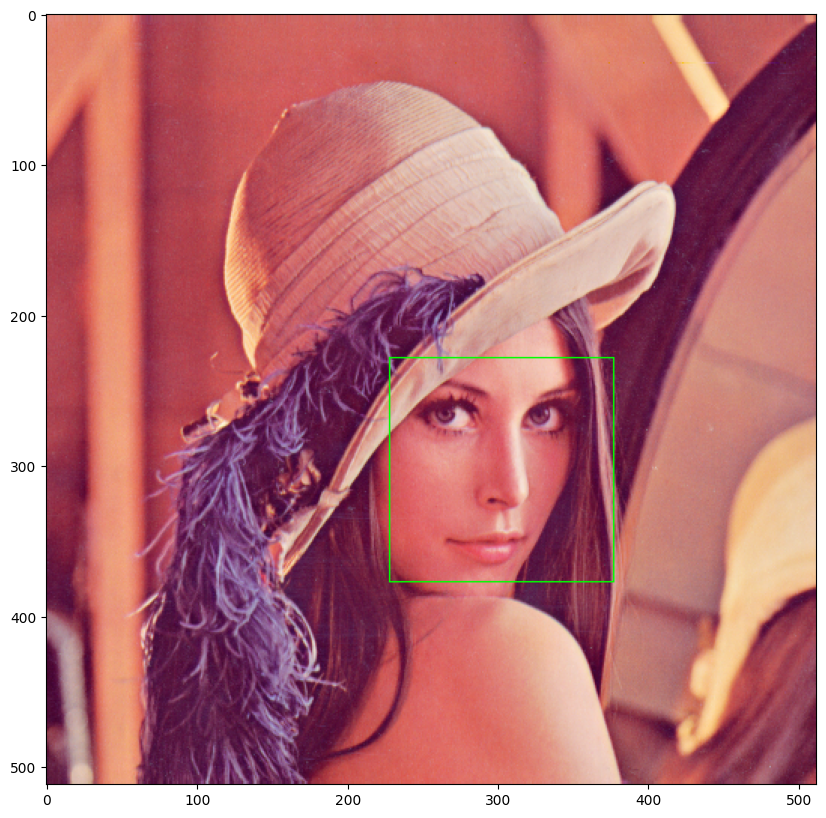

In [10]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt

import dlib

# carrega uma imagem para detectar o rosto
img1 = cv2.imread('lena.png')
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

# Inicializa o detector dlib
detector = dlib.get_frontal_face_detector()

# Faz deteção das faces
faces = detector(img1_gray)

print(faces)


for face in faces:
        x,y = face.left(), face.top()  # topo esquerda
        x1,y1 = face.right(), face.bottom() #baixo direita

        cv2.rectangle(img1, (x, y), (x1, y1), (0, 255, 0), 1)


# Exibe imagem
plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)); plt.show();


## Detecção dos landmarks da face

Para predição dos landmarks uma rede neural já treinada é utilizada, serão preditos 68 pontos da face.

Para carregar os pesos da rede é necessário fazer o download em:

[hape_predictor_68_face_landmarks.dat](http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2)

#### Dlib positions
- ("mouth", (48, 68)),
- ("right_eyebrow", (17, 22)),
- ("left_eyebrow", (22, 27)),
- ("right_eye", (36, 42)),
- ("left_eye", (42, 48)),
- ("nose", (27, 35)),
- ("jaw", (0, 17))



rectangles[[(228, 228) (377, 377)]]


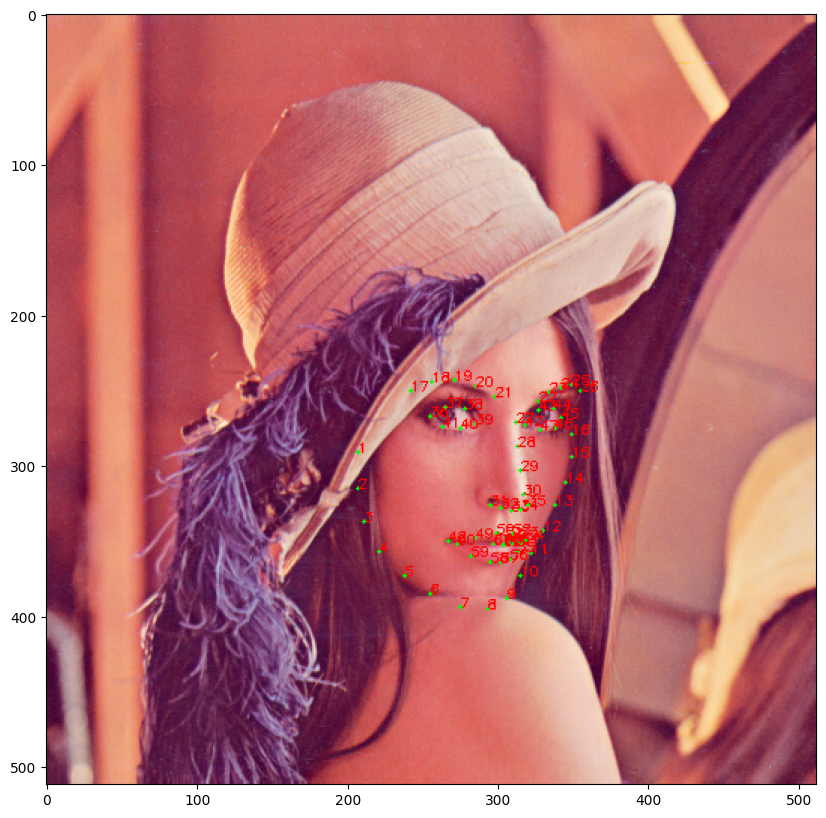

In [11]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt

import dlib

# carrega uma imagem para detectar o rosto
img1 = cv2.imread('lena.png')
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

# Inicializa o detector dlib
detector = dlib.get_frontal_face_detector()

# Inicializa o identificador de Landmark identifier. Você ter esse arquiva na pasta do projeto
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")


# Faz deteção das faces
faces = detector(img1_gray)

print(faces)

# para todas faces detectadas
for face in faces:
        # Faz a predição dos landmarks
        shape = predictor(img1_gray, face)
        for i in range(1,68): #São 68 landmark em cada face
            # Desenha um circulo e exibe o indice do landmark
            # shape.part(i).x devolve o valor x da coordenada
            cv2.circle(img1, (shape.part(i).x, shape.part(i).y), 1, (0,255,0), thickness=-1)
            # Escreve o indice de cada landmark na imagem
            cv2.putText(img1, str(i), (shape.part(i).x,shape.part(i).y), fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, fontScale=0.3, color=(0, 0, 255))

# Exibe imagem
plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)); plt.show();


## Desafio 1

Implemente um código que faz o crop de uma das regiões preditas.

Exemplo: crop da boca, sobrancelha, olho, nariz ou boca.

In [12]:
### Implemente sua solução aqui...






## Desafio 2

Faça um código capaz de detectar em tempo real as landmarks face pela webcam.

In [13]:
### Implemente sua solução em um arquivo .py



## Detector de fadiga

O detector de fadiga pode ser elaborado a partir a abertura dos olhos, o código a baixo foi inspirado no link:
[Artigo de refência](https://bit.ly/2CYC7Gf)

Além deste artigo, vamos utilizar algumas outras funções da OpenCV que ainda não conhecemos.

cv2.convexHull = Cria um contorno com base nos pontos. https://learnopencv.com/convex-hull-using-opencv-in-python-and-c/


#### Dlib positions
- ("mouth", (48, 68)),
- ("right_eyebrow", (17, 22)),
- ("left_eyebrow", (22, 27)),
- ("right_eye", (36, 42)),
- ("left_eye", (42, 48)),
- ("nose", (27, 35)),
- ("jaw", (0, 17))

In [ ]:
from math import dist
import time
import numpy as np
import dlib
import cv2



# definir constantes
EYE_AR_THRESH = 0.3
EYE_AR_CONSEC_FRAMES = 40
COUNTER = 0

def eye_aspect_ratio(eye):
    # calcula a distancia euclidiana vertical os olhos
    # vertical eye landmarks (x, y)-coordinates
    A = dist(eye[1], eye[5])
    B = dist(eye[2], eye[4])

    # # calcula a distancia euclidiana horizontal os olhos
    # eye landmark (x, y)-coordinates
    C = dist(eye[0], eye[3])

    # calcula uma taxa de abertura dos olhos
    ear = (A + B) / (2.0 * C)

    # return the eye aspect ratio
    return ear


# inicializa o detector e preditor do dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# pega os índices do previsor, para olhos esquerdo e direito
(lStart, lEnd) = (42, 48)
(rStart, rEnd) = (36, 42)

# inicializar vídeo
vs = cv2.VideoCapture(0)


# loop sobre os frames do vídeo
while True:
    ret, frame = vs.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # detectar faces (grayscale)
    rects = detector(gray, 0)

    # loop nas detecções de faces
    for rect in rects:

        shape = predictor(gray, rect)
        #devolve shape em uma lista coords
        coords = np.zeros((shape.num_parts, 2), dtype=int)
        for i in range(0,68): #São 68 landmark em cada face
            coords[i] = (shape.part(i).x, shape.part(i).y)

        # extrair coordenadas dos olhos e calcular a proporção de abertura
        leftEye = coords[lStart:lEnd]
        rightEye = coords[rStart:rEnd]

        leftEAR = eye_aspect_ratio(leftEye)
        rightEAR = eye_aspect_ratio(rightEye)

        # ratio média para os dois olhos
        ear = (leftEAR + rightEAR) / 2.0

        # convex hull cria um contorno com base nos pontos
        leftEyeHull = cv2.convexHull(leftEye)
        rightEyeHull = cv2.convexHull(rightEye)
        cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
        cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

        # checar ratio x threshold
        if ear < EYE_AR_THRESH:
            COUNTER += 1

            # dentro dos critérios
            if COUNTER >= EYE_AR_CONSEC_FRAMES:
                cv2.putText(frame, "[ALERTA] FADIGA!", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # caso acima do threshold, resetar o contador e desligar o alarme
        else:
            COUNTER = 0
            # desenhar a proporção de abertura dos olhos
        cv2.putText(frame, "EAR: {:.2f}".format(ear), (300, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # Exibe resultado
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    # tecla para sair do script "q"
    if key == ord("q"):
        break

# clean
cv2.destroyAllWindows()
vs.release()

## Desafio 3

Inspirado na solução do detector de fadiga, implemente um código que faz a deteção de emoção. Ou seja, detecta se a pessoa esta sorrindo ou não.



In [ ]:
# Implemente sua solução aqui......



